# Mesa Schelling example - Schelling Segregation Model

[[Code explanation]](https://towardsdatascience.com/introduction-to-mesa-agent-based-modeling-in-python-bcb0596e1c9a) **Note that the final interactive visualization part we will cover in the later parts of the course**

## Background

The Schelling (1971) segregation model is a classic of agent-based modeling, demonstrating how agents following simple rules lead to the emergence of qualitatively different macro-level outcomes. Agents are randomly placed on a grid. There are two types of agents, one constituting the majority and the other the minority. All agents want a certain number (generally, 3) of their 8 surrounding neighbors to be of the same type in order for them to be happy. Unhappy agents will move to a random available grid space. While individual agents do not have a preference for a segregated outcome (e.g. they would be happy with 3 similar neighbors and 5 different ones), the aggregate outcome is nevertheless heavily segregated.

# 1. Create the Basic Agent/Model

In [2]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.space import SingleGrid

In [3]:
# Data collection

def get_stable_region(center_agent, stable_agents_list):
    
    neighbors = center_agent.model.grid.get_neighbors(center_agent.pos, False)
    for neighbor in neighbors:
        if neighbor in stable_agents_list and center_agent.traits_vector == neighbor.traits_vector:
            stable_agents_list.remove(neighbor)
            get_stable_region(neighbor, stable_agents_list)
    
def get_stable_regions_data(model):
    # For our purposes, a cultural region can be defined as a set of contiguous sites with an identical culture.

    stable_regions = 0
    stable_agents = model.schedule.agents.copy()
    
    for stable_agent in stable_agents:
        
        stable_agents.remove(stable_agent)
        get_stable_region(stable_agent, stable_agents)
        stable_regions += 1
    
    return stable_regions

In [4]:
# Agent

class AxelrodAgent(Agent):
    
    # 1 Initialization
    def __init__(self, pos, model, traits_vector_size, trait_values_number):
                
        super().__init__(pos, model)
        self.pos = pos
        self.traits_vector = self.random.choices(range(trait_values_number), k=traits_vector_size)
        self.traits_vector_size = traits_vector_size
        
    # 2 Step function
    def step(self):
        
        neighbors = self.model.grid.get_neighbors(self.pos, False)
        
        other_agent = self.random.choice(neighbors)
        
        # With probability equal to their cultural similarity, these two sites interact
        cultural_similarity = sum([len(set(i)) == 1 for i in zip(self.traits_vector,other_agent.traits_vector)]) / self.traits_vector_size
        
        if self.traits_vector == other_agent.traits_vector or self.random.random() > cultural_similarity:
            return
        
        traits_diff_mask = [len(set(i)) == 1 for i in zip(self.traits_vector,other_agent.traits_vector)]
        traits_diff_indices = [i for i, x in enumerate(traits_diff_mask) if x == False]
        copy_index = self.random.choice(traits_diff_indices)
        
        self.traits_vector[copy_index] = other_agent.traits_vector[copy_index]


In [5]:
from mesa.datacollection import DataCollector

# Model

class AxelrodModel(Model):
    '''
    Model class for the Schelling segregation model.
    '''

    def __init__(self, height, width, traits_vector_size, trait_values_number):
    
        super().__init__()
        self.height = height
        self.width = width

        self.schedule = RandomActivation(self)
        self.grid = SingleGrid(height, width, torus=True)

        self.stable_regions = 0
        
        self.datacollector = DataCollector({"Stable_regions": "stable_regions"})
        
        self.running = True

        for x in range(width):
            for y in range(height):
                agent = AxelrodAgent((x, y), self, traits_vector_size, trait_values_number)
                self.grid.position_agent(agent, (x, y))
                self.schedule.add(agent)

    def step(self):

        self.stable_regions = 0  # 1 Reset counter of happy agents
        
        self.schedule.step()
        self.stable_regions = get_stable_regions_data(self)
        
        self.datacollector.collect(self)
        
        # 2 Stop the model if only one culture converged
        if self.stable_regions == 1:
            self.running = False


# 2. Run the Agent/Model Basic

<font color='green'>**HINT:** Now we instantiate a model instance: a 10x10 grid, with an 80% chance of an agent being placed in each cell, approximately 20% of agents set as minorities, and agents wanting at least 3 similar neighbors.</font>

In [23]:
model = AxelrodModel(10, 10, 5, 10)
model.step()

while model.running and model.schedule.steps < 8000:
    model.step()

print('The Axelrod Model ran for {} steps'.format(model.schedule.steps))

The Axelrod Model ran for 401 steps


# 3. Visualize the Agent/Model

In [5]:
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer


def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "Layer": 0,
                 "r": 0.5,
                 "Color": "Blue",
                 "text_color": "white"}
    
    similar = 0
    neighbors = agent.model.grid.neighbor_iter(agent.pos)
    for neighbor in neighbors:
        if sum(len(set(i))==1 for i in zip(agent.traits_vector,neighbor.traits_vector)) > 0:
            similar += 1

    portrayal["text"] = str(similar)
        
    return portrayal

grid = CanvasGrid(agent_portrayal, 10, 10, 500, 500)
server = ModularServer(AxelrodModel,
                       [grid],
                       "Schelling Model",
                       {"width":10, "height":10, "traits_vector_size":5, "trait_values_number":5})

# 4. Run the Agent/Model Visualization

In [6]:
server.port = 8522 # The default
#server.launch()

# 5. Collect data to Analyze the Agent/Model

# 6. Run the Agent/Model Analysis

In [24]:
model = AxelrodModel(10, 10, 5, 10)
model.step()

while model.running and model.schedule.steps < 8000:
    model.step()

print('The Axelrod Model ran for {} steps'.format(model.schedule.steps))

The Axelrod Model ran for 651 steps


In [25]:
import pandas as pd

model_out = model.datacollector.get_model_vars_dataframe()
model_out.tail()

,Stable_regions
646,4
647,3
648,2
649,2
650,1


<AxesSubplot:>

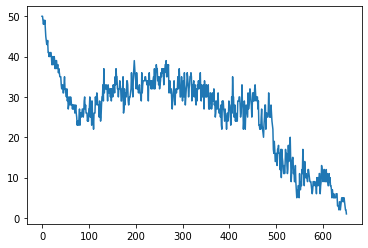

In [26]:
model_out.Stable_regions.plot()

# 7. Create iteration Batch of the Agent/Model

In [27]:
params = {"height": 10, "width": 10, "traits_vector_size": range(5, 26, 5), "trait_values_number": 5}

# 8. Run the Agent/Model Batch

In [28]:
from mesa.batchrunner import batch_run

results = batch_run(
    AxelrodModel,
    parameters=params,
    iterations=3,
    max_steps=800,
    display_progress=True,
)

15it [00:04,  3.56it/s]


# 9. Run the Batch data Analysis

In [29]:
import pandas as pd

results_df = pd.DataFrame(results)
results_df.tail()

,RunId,iteration,Step,height,width,traits_vector_size,trait_values_number,Stable_regions
10,10,2,706,10,10,10,5,1
11,11,1,800,10,10,25,5,49
12,12,2,800,10,10,20,5,36
13,13,2,800,10,10,15,5,39
14,14,2,800,10,10,25,5,49


Task: Find out how homophily (level of neighbour similaritly) influences the final segragation of agents using the mean or box plot. You should be able to plot the average outcome for each homophily value.

**hint** Your plot should look similar to [this paper](https://www.jasss.org/15/1/6.html). Not neccesarily with Moran's I, but the transition should be visible

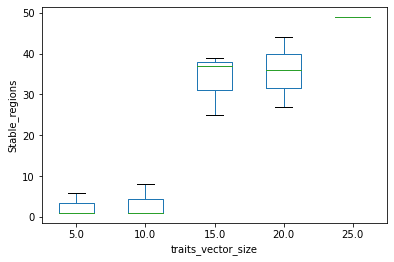

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

results_df.groupby(by=["RunId"]).median().boxplot(by ='traits_vector_size', column =['Stable_regions'], grid=False)
plt.suptitle(None)
plt.title(None)
plt.ylabel("Stable_regions")
plt.savefig('axelrod_trait_vector_paper_10.eps')

In [189]:
results_df.groupby(by=["RunId"]).median()

,iteration,Step,height,width,traits_vector_size,trait_values_number,Stable_regions
RunId,,,,,,,
0,0.0,800.0,10.0,10.0,5.0,15.0,4.0
1,1.0,800.0,10.0,10.0,5.0,15.0,11.0
2,0.0,800.0,15.0,10.0,5.0,15.0,11.0
3,1.0,800.0,15.0,10.0,5.0,15.0,35.0
4,0.0,800.0,20.0,10.0,5.0,15.0,54.0
5,1.0,800.0,20.0,10.0,5.0,15.0,56.0
6,2.0,800.0,10.0,10.0,5.0,15.0,13.0
7,2.0,800.0,15.0,10.0,5.0,15.0,40.0
8,3.0,800.0,10.0,10.0,5.0,15.0,1.0


<AxesSubplot:title={'center':'Stable_regions'}, xlabel='height'>

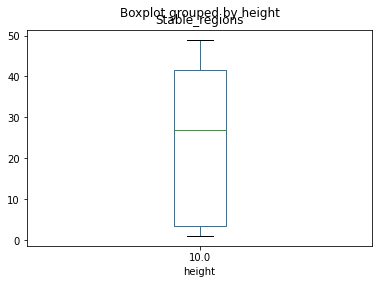

In [31]:
results_df.groupby(by=["RunId"]).median().boxplot(by ='height', column =['Stable_regions'], grid=False)

# Appendix

# 3. Visualize the Agent/Model - interactive advanced

In [ ]:
from mesa.visualization.modules import CanvasGrid, ChartModule, TextElement
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter

class HappyElement(TextElement):
    '''
    Display a text count of how many happy agents there are.
    '''

    def render(self, model):
        return "Happy agents: " + str(model.happy)


def agent_portrayal(agent):
    '''
    Portrayal Method for canvas
    '''
    if agent is None:
        return
    portrayal = {"Shape": "circle", "r": 0.5, "Filled": "true", "Layer": 0}

    if agent.type == 0:
        portrayal["Color"] = "Red"
    else:
        portrayal["Color"] = "Blue"
        
    return portrayal

happy_element = HappyElement()
canvas_element = CanvasGrid(agent_portrayal, 20, 20, 500, 500)
happy_chart = ChartModule([{"Label": "Happy", "Color": "Black"}], data_collector_name="datacollector")

model_params = {
    "density":0.8, 
    "width":20, 
    "height":20, 
    "minority_pc":0.2, 
    "homophily":UserSettableParameter(
        "slider",
        "Number of similar agents",
        3,
        1,
        8,
        1,
        description="Choose how many similar agents needed to be happy",
    ),
}

server = ModularServer(SchellingModelAnalysis,
                       [canvas_element, happy_element, happy_chart],
                       "Schelling’s Segregation Model",
                       model_params)

In [ ]:
server.port = 8521 # The default
#server.launch()